# FIN41360 Assignment 1 – Data Sanity Checks

This notebook checks that the Fama–French datasets for Assignment 1 are correctly
downloaded, parsed, and aligned:

- 30 Industry Portfolios (value-weighted, monthly)
- Fama–French 3-factor model (monthly)
- Fama–French 5-factor (2x3) model (monthly)

We’ll verify shapes, sample periods, and basic summary statistics.

> EXPLAIN: This notebook is purely for validation so that we can trust the
> inputs before building mean–variance frontiers.

In [1]:
# Core imports
import pandas as pd
import numpy as np

# Local helpers for this assignment
from fin41360.process_french import (
    load_industry_30_monthly,
    load_ff3_monthly,
    load_ff5_monthly,
)

# EXPLAIN: Keeping all French-data logic in fin41360.process_french
# avoids duplicating parsing/cleaning code in notebooks.

In [2]:
# Load 30-industry value-weighted monthly gross returns
ind = load_industry_30_monthly()

# Load FF3 and FF5 factors (excess returns) + RF (gross)
ff3, rf3 = load_ff3_monthly()
ff5, rf5 = load_ff5_monthly()

print("Industries:", ind.shape, ind.index.min().date(), "→", ind.index.max().date())
print("FF3:", ff3.shape, "RF len:", len(rf3))
print("FF5:", ff5.shape, "RF len:", len(rf5))

Industries: (552, 30) 1980-01-31 → 2025-12-31
FF3: (552, 3) RF len: 552
FF5: (552, 5) RF len: 552


In [3]:
# Industry portfolios: mean and volatility
ind_stats = ind.describe().T[["mean", "std"]]
ind_stats.head()

# EXPLAIN: Values here are gross returns (R = 1 + r); for interpretation
# you may mentally subtract 1 to get net monthly returns.

,mean,std
Food,1.010910,0.041520
Beer,1.011961,0.049121
Smoke,1.014728,0.064563
Games,1.012291,0.071404
Books,1.008700,0.059752


In [ ]:
ind.head()           # first rows
ind.tail()           # last rows
ind.describe().T     # summary stats
ind.sample(10)       # random sample of rows
list(ind.columns)    # column names


['Food',
 'Beer',
 'Smoke',
 'Games',
 'Books',
 'Hshld',
 'Clths',
 'Hlth',
 'Chems',
 'Txtls',
 'Cnstr',
 'Steel',
 'FabPr',
 'ElcEq',
 'Autos',
 'Carry',
 'Mines',
 'Coal',
 'Oil',
 'Util',
 'Telcm',
 'Servs',
 'BusEq',
 'Paper',
 'Trans',
 'Whlsl',
 'Rtail',
 'Meals',
 'Fin',
 'Other']

In [ ]:
from tabulate import tabulate
print(tabulate(ind.head(20), headers="keys", tablefmt="github"))
import matplotlib.pyplot as plt

# Plot a few industry series to eyeball behaviour
ind[["Food", "Beer", "Smoke", "Games"]].iloc[:120].add(-1).plot(figsize=(10, 4))
plt.title("Selected industry net monthly returns (first 10 years)")
plt.axhline(0, color="black", linewidth=0.5)
plt.show()
from fin41360.process_french import load_industry_30_monthly, load_ff3_monthly
from fin41360.mv_frontier import compute_moments_from_gross, gmv_weights, tangency_weights, efficient_frontier

ind_gross = load_industry_30_monthly()
ind_net = ind_gross - 1.0

mu, Sigma = compute_moments_from_gross(ind_gross)

ff3, rf = load_ff3_monthly()
rf_mean = float((rf - 1.0).mean())  # average monthly RF (net)

w_gmv = gmv_weights(Sigma)
w_tan = tangency_weights(mu, Sigma, rf_mean)

target_means, vols, weights_grid = efficient_frontier(mu, Sigma)

## Scope 2 – 30-Industry MV Frontier (Sample Estimates)

The following cells construct the **unconstrained mean–variance frontier** for the
30 Fama–French industry portfolios using closed-form formulas, and identify the
GMV and tangency portfolios for Question 2(a)–(b).

> EXPLAIN: Scope 1 cells above focus on data sanity checks; scope 2 cells below
> perform the actual frontier and key-portfolio computations.

In [13]:
# Scope 2: Setup for MV frontier

import matplotlib.pyplot as plt

from fin41360.mv_frontier import (
    compute_moments_from_gross,
    gmv_weights,
    tangency_weights,
    efficient_frontier,
    portfolio_stats,
)

plt.style.use("seaborn-v0_8")  # EXPLAIN: simple, readable default style

# Use the same industry and RF data loaded above
ind_gross = ind  # (T, 30), R = 1 + r

# Re-load RF to be explicit (keeps notebook self-contained if re-run from here)
ff3_for_frontier, rf_gross_for_frontier = load_ff3_monthly()

ind_net = ind_gross - 1.0
rf_net = rf_gross_for_frontier - 1.0

print("Scope 2 sample period:")
print("Industries:", ind_net.shape, ind_net.index.min().date(), "→", ind_net.index.max().date())
print("RF:", rf_net.shape, rf_net.index.min().date(), "→", rf_net.index.max().date())

# Compute sample mean vector and covariance matrix (net monthly returns)
mu, Sigma = compute_moments_from_gross(ind_gross)

# Average monthly risk-free rate over the same sample
rf_mean = float(rf_net.mean())
print(f"Average monthly risk-free rate (net): {rf_mean:.4%}")

Scope 2 sample period:
Industries: (552, 30) 1980-01-31 → 2025-12-31
RF: (552,) 1980-01-31 → 2025-12-31
Average monthly risk-free rate (net): 0.3297%


## Scope 2B/2C – Bayes–Stein Frontiers (Means and Means+Covariance)

In this section we:

- Apply Jorion-style Bayes–Stein shrinkage to the **mean vector** of industry returns.
- Apply a **light covariance shrinkage** towards a scaled identity matrix.
- Construct three frontiers for the 30 industries:
  - **Sample**: `(mu, Sigma)`
  - **BS-mean**: `(mu_bs, Sigma)`
  - **BS-mean+cov**: `(mu_bs, Sigma_bs)`
- Compare GMV and tangency portfolios across these frontiers, focusing on
  expected excess return, volatility, and Sharpe ratio.

> EXPLAIN: We shrink towards the cross-sectional grand mean (Jorion, 1986)
> and use a modest covariance shrinkage (λ ≈ 0.1) because T >> N in our
> sample. Alternatives (e.g., constant-correlation target, Ledoit–Wolf)
> are possible but add complexity without clear benefits in this setting.

In [16]:
# Scope 2B/2C: Bayes–Stein means and covariance

from fin41360.bayes_stein import bayes_stein_means, shrink_covariance_identity
from fin41360.analyse_frontiers import compare_frontiers, print_sharpe_comparison

# We already have ind_gross, mu, Sigma, rf_net, rf_mean from earlier cells
T = ind_gross.shape[0]
N = ind_gross.shape[1]
print(f"Sample length T={T}, number of industries N={N}")

# --- Bayes–Stein shrinkage of means (towards cross-sectional grand mean) ---
bs_result = bayes_stein_means(mu, Sigma, T=T)
mu_bs = bs_result.mu_bs
print(f"Bayes–Stein shrinkage intensity (means): {bs_result.shrinkage_intensity:.3f}")
print(f"Grand mean target (monthly net): {bs_result.target_mean:.4%}")

# --- Light covariance shrinkage towards scaled identity ---
Sigma_bs = shrink_covariance_identity(Sigma, shrinkage=0.1)

# Sanity check: all covariance matrices should be symmetric and positive semi-definite
for name, S in [("sample", Sigma), ("BS-cov", Sigma_bs)]:
    eigvals = np.linalg.eigvalsh(S)
    print(f"{name} Sigma: min eigenvalue = {eigvals.min():.4e}, max = {eigvals.max():.4e}")

Sample length T=552, number of industries N=30
Bayes–Stein shrinkage intensity (means): 0.005
Grand mean target (monthly net): 1.0853%
sample Sigma: min eigenvalue = 2.9721e-04, max = 7.0464e-02
BS-cov Sigma: min eigenvalue = 6.7893e-04, max = 6.3829e-02


In [17]:
# Scope 2B/2C: Compare GMV and tangency across sample and Bayes–Stein frontiers

# Package frontier definitions in terms of (mu, Sigma)
frontiers = {
    "sample": (mu, Sigma),
    "bs_mean": (mu_bs, Sigma),
    "bs_mean_cov": (mu_bs, Sigma_bs),
}

summary = compare_frontiers(frontiers, rf_mean)
summary


,portfolio,label,mean,vol,excess_mean,sharpe
0,GMV,sample,0.009733,0.031396,0.006435,0.204973
1,TAN,sample,0.017633,0.046860,0.014336,0.305928
2,GMV,bs_mean,0.009738,0.031396,0.006441,0.205144
3,TAN,bs_mean,0.017556,0.046715,0.014259,0.305236
4,GMV,bs_mean_cov,0.010071,0.032117,0.006773,0.210897
5,TAN,bs_mean_cov,0.015950,0.043897,0.012653,0.288244


In [18]:
# Scope 2C: Rule-based commentary on Sharpe ratio changes (Question 2c)

print_sharpe_comparison(summary, base_label="sample")

[bs_mean] Tangency Sharpe change vs sample: -0.001 → Sharpe ratio is very similar to the sample-based frontier.
[bs_mean_cov] Tangency Sharpe change vs sample: -0.018 → Sharpe ratio is very similar to the sample-based frontier.


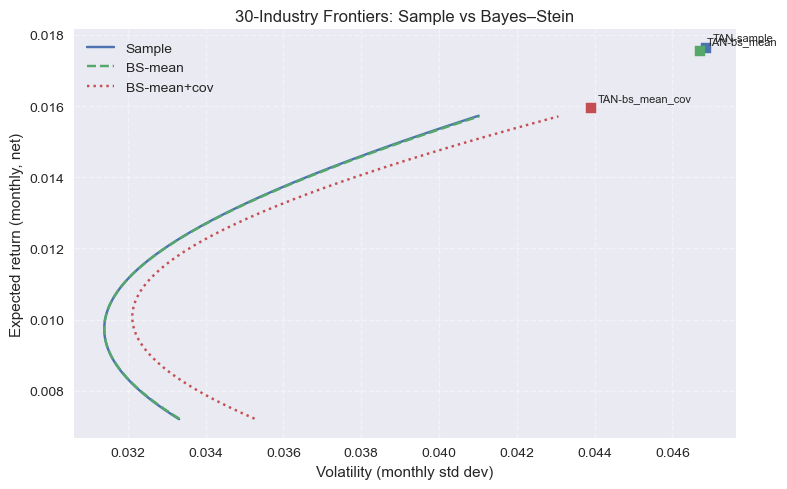

In [19]:
# Scope 2B/2C: Overlay plot of sample vs Bayes–Stein frontiers

# Use the summary table to pick a mu-range that includes GMV and TAN
# for all three frontiers, so the key portfolios lie on the plotted curves.
tan = summary[summary["portfolio"] == "TAN"].set_index("label")
gmv = summary[summary["portfolio"] == "GMV"].set_index("label")

mu_targets = np.concatenate([
    tan["mean"].values,
    gmv["mean"].values,
    mu,  # individual industry means
])
mu_min = float(mu_targets.min()) - 0.001
mu_max = float(mu_targets.max()) + 0.001

# Generate frontiers for all three (using the same mu/Sigma variants)
front_sample_means, front_sample_vols, _ = efficient_frontier(mu, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bsmean_means, front_bsmean_vols, _ = efficient_frontier(mu_bs, Sigma, n_points=200, mu_min=mu_min, mu_max=mu_max)
front_bscov_means, front_bscov_vols, _ = efficient_frontier(mu_bs, Sigma_bs, n_points=200, mu_min=mu_min, mu_max=mu_max)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_sample_vols, front_sample_means, label="Sample", color="C0")
ax.plot(front_bsmean_vols, front_bsmean_means, label="BS-mean", color="C1", linestyle="--")
ax.plot(front_bscov_vols, front_bscov_means, label="BS-mean+cov", color="C2", linestyle=":")

# Highlight GMV and tangency portfolios for each frontier
for label, color in {
    "sample": "C0",
    "bs_mean": "C1",
    "bs_mean_cov": "C2",
}.items():
    # Tangency
    mu_tan_f = float(tan.loc[label, "mean"])
    vol_tan_f = float(tan.loc[label, "vol"])
    ax.scatter(vol_tan_f, mu_tan_f, color=color, marker="s")
    ax.annotate(f"TAN-{label}", (vol_tan_f, mu_tan_f), xytext=(5, 5),
                textcoords="offset points", fontsize=8)

    # GMV
    mu_gmv_f = float(gmv.loc[label, "mean"])
    vol_gmv_f = float(gmv.loc[label, "vol"])
    ax.scatter(vol_gmv_f, mu_gmv_f, color=color, marker="o")
    ax.annotate(f"GMV-{label}", (vol_gmv_f, mu_gmv_f), xytext=(-35, -10),
                textcoords="offset points", fontsize=8)

ax.set_xlabel("Volatility (monthly std dev)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("30-Industry Frontiers: Sample vs Bayes–Stein")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# EXPLAIN: By expanding the target-mean range using both GMV and tangency
# means, we ensure that all key portfolios lie on the plotted frontiers.
# This plot directly supports Question 2(c) by showing how shrinkage of
# means and covariance changes the location and shape of the efficient
# frontier and both GMV and tangency portfolios.

In [20]:
# Scope 2: GMV and tangency portfolios

# Global minimum-variance portfolio
w_gmv = gmv_weights(Sigma)
mu_gmv, vol_gmv = portfolio_stats(w_gmv, mu, Sigma)

# Tangency portfolio (unconstrained, using average RF)
w_tan = tangency_weights(mu, Sigma, rf_mean)
mu_tan, vol_tan = portfolio_stats(w_tan, mu, Sigma)

print(f"GMV:  mean={mu_gmv:.4%}, vol={vol_gmv:.4%}")
print(f"TAN:  mean={mu_tan:.4%}, vol={vol_tan:.4%}")

GMV:  mean=0.9733%, vol=3.1396%
TAN:  mean=1.7633%, vol=4.6860%


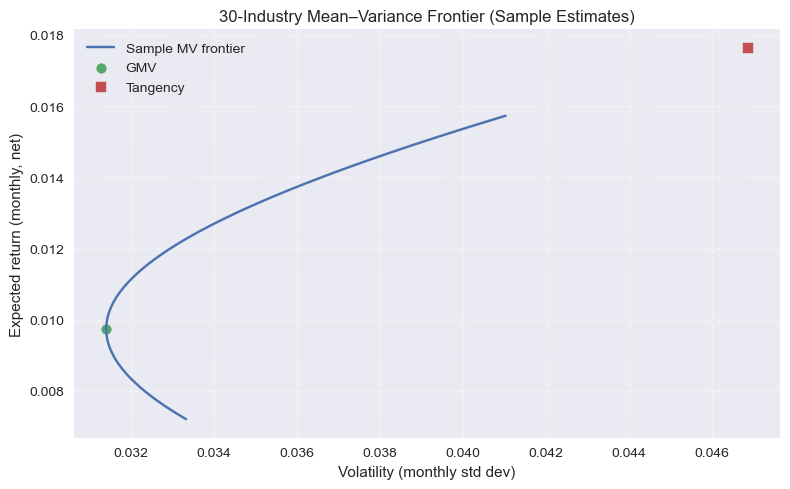

In [21]:
# Scope 2: Efficient frontier and plot (sample estimates)

# Generate frontier (sample estimates)
front_means, front_vols, front_weights = efficient_frontier(mu, Sigma, n_points=200)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(front_vols, front_means, label="Sample MV frontier", color="C0")

ax.scatter(vol_gmv, mu_gmv, color="C1", marker="o", label="GMV")
ax.scatter(vol_tan, mu_tan, color="C2", marker="s", label="Tangency")

ax.set_xlabel("Volatility (monthly std dev)")
ax.set_ylabel("Expected return (monthly, net)")
ax.set_title("30-Industry Mean–Variance Frontier (Sample Estimates)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# EXPLAIN: All quantities here are monthly and in net-return units.
# For the report, you may want to annualise means and volatilities
# and compute Sharpe ratios using the average RF.